In [0]:
pip install tensorflow

Python interpreter will be restarted.
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=542d261c66aadb9e73090aaccd05cf534efbbe264bc428b7a87d535671d07545
  Stored in directory: /root/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
Python interpreter will be restarted.


In [0]:
# "Classic" Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Streams
import io

# Images
from PIL import Image

# Pyspark
import pyspark
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf, element_at, split
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Transfer learning
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [0]:
# Define the path to load all the images contained in directory light_training_4
path_train_set_light = 'dbfs:/FileStore/tables/resources/light_training_4/*/*'

In [0]:
# Load the images with spark.read.format('image') from path_train_set_light
img_train_light = spark.read.format('image').load(path_train_set_light, inferschema=True)

In [0]:
# Print the schema of img_train_light dataframe in a tree format
img_train_light.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [0]:
img_train_light.show()

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-859062890440904> in <module>
----> 1 img_train_light.show()

/databricks/spark/python/pyspark/sql/dataframe.py in show(self, n, truncate, vertical)
    500 
    501         if isinstance(truncate, bool) and truncate:
--> 502             print(self._jdf.showString(n, 20, vertical))
    503         else:
    504             try:

/databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1302 
   1303         answer = self.gateway_client.send_command(command)
-> 1304         return_value = get_return_value(
   1305             answer, self.gateway_client, self.target_id, self.name)
   1306 

/databricks/spark/python/pyspark/sql/utils.py in deco(*a, **kw)
    115     def deco(*a, **kw):
    116         try:
--> 117             return f(*a, **kw)
    118         except py4j.protocol.Py4JJava

https://docs.databricks.com/data/data-sources/image.html  

Databricks recommends that you use the binary file data source to load image data into the Spark DataFrame as raw bytes
Indeed, the image data source decodes the image files during the creation of the Spark DataFrame, increases the data size, and introduces limitations in the following scenarios:

1) Persisting the DataFrame: If you want to persist the DataFrame into a Delta table for easier access, you should persist the raw bytes instead of the decoded data to save disk space.

2) Shuffling the partitions: Shuffling the decoded image data takes more disk space and network bandwidth, which results in slower shuffling. You should delay decoding the image as much as possible.

3) Choosing other decoding method: The image data source uses the Image IO library of javax to decode the image, which prevents you from choosing other image decoding libraries for better performance or implementing customized decoding logic.

-> Those limitations can be avoided by using the **binary file** data source to load image data and decoding only as needed.

### Load binaryfile images

https://docs.databricks.com/data/data-sources/binary-file.html

Databricks Runtime supports the binary file data source, which reads binary files and converts each file into a single record that contains the raw content and metadata of the file. The binary file data source produces a DataFrame with the following columns and possibly partition columns:

- path (StringType): The path of the file.

- modificationTime (TimestampType): The modification time of the file. In some Hadoop FileSystem implementations, this parameter might be unavailable and the value would be set to a default value.

- length (LongType): The length of the file in bytes.

- content (BinaryType): The contents of the file.

To read binary files, specify the data source format as binaryFile.

In [0]:
# Create dataframe by loading train_set_light with binaryFile format
binary_train = spark.read.format("binaryFile").load(path_train_set_light)

# Print the schema of binary_train dataframe in a tree format
binary_train.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [0]:
# Display image data loaded using the binary data source
# (image preview is automatically enabled for file names with an image extension)
display(binary_train)

path modificationTime length content dbfs:/FileStore/tables/resources/light_training_4/Kiwi/r_145_100.jpg 2022-07-06T16:20:31.000+0000 5307 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgo= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABWv0lEQVR42rS8B3hi95k9PNndZFN2bE9T7xJqIIooogsQHdEEqEsgJLoACQHqvffee58+tsfjksSO46xTHMfOrpM4my/FcbLxpieOy8yofe+FmcnYTr7n+W/+3zzvc+cOYgQcznvec363nDr5P/xzHChkB/46Oj5G/jo5DNQHh3cPTk7uHh8dIf86Ojm6e3z3Q9jeq2P4ycHxMfzo5AieApvD28jjJ7dPDt89OfnzyfEfv/781f2lwaXRltWJju25vkur40/uLVzemPuPb71wcvzBydEHyK8/PjxG/jqB17p9eO/NBP8cwCvC6yLvLfA3bA4Cb+/w+OgYeU8HJ8H3e+9THN4veDy4g3wm5DnHyPs8Rt7zw5/91Mk//Cf4wgcBMO698PFBAIu7AciOkULew13k4xzefu/Pv3v91W9866Uvv/zC0y8+c/3Z61vPXVu/dXH+6f2ZtdHG2W7nTJd9pqt6tts91emc6a4dbnasTXbeurT85acuvf7NF9547ZtvfPfbr7/2yq9+9Uvk195/IfiDfP7jo7++LXjNw6MgnEeBL/c48B0HAfsYXg/ACjwnCFag/jGwjk6C397HC0Hl6Ojg8PBu8JE7dw/vHJ3cOQx8dYfH8Phv3nn7nV/88M3XX9pZGJjr8093OqfbbP21xYPuwm6LssuS22uRDbsUM37tuCdvtEbV55APOFWdFkWHVdXjKhhqqNoYb72yPHJtfWpnYeQrt668/ePv/uZXP7nzwR9PAl8PgADgHAR49ODdIlAeHwbfM8Lo+90Q/CDHf62/fpaHPubRPwLWUeCFA+8sQCKoo0DBI4eBtwW99vDz7hze+66O7r7/7a89uzXfO9vrmm43j3gKBpzKSY9mxCEdNAuHLaJRm2TIzO+vYo/aeUNW3rAtZ9wpXmrQzft14zXqPou02ZDT79SO+ctH/PpWS96Qz7A44L28NvbfP/nuyfF7x3fePzy48xBIgfcD0B18GCB1AKbDe0w/vgff0UOQfQysv/Hn1P+KVgdIQ50cHiB1fI/hAMfBIfKi8PUeHt45uBvox8DzD++889YPoY92ptsXe2wzjSXjtfKxauGIOXvMwhmuYg1XMCYt3HmnaMTEHrJkD1jYAyYW1LCVN1Mrm4DHrfyJanGfkTPulE571JM16kGrZNqjmfAV9tcVT3RWg8Y9sb/6l9/9ClQy+G09/FZPgpSHdxSE5V5/Pfjpvec84NHfA+5/2YbHCFh3A3V4/IDhiKBC1wVF5ODdd3/zozdf++F3X37jG8+9fGt3fbhuttmw1FK8WK8et2bP2DlTFuaIngw1VkmbMDGmbdwxC3vEwuqvoo9ZuWO2bNhOOvjDJvaohTNu5QKUU9UiqGETF2rGJQXs2quEbWZps0XZU1dxa3/pxaevfuulL775n6+996ffA6FAIoFfBw8xLtCDRw/V/59gPaRQCF73X+bkKPBCyPQ5gGa8/Zff//z1bz57fXt8aaBmpce+OWDf7jNP1+YueeUrHumCgzdnYc2YGMPlpFEDZdLMnDAzxyzMcStr1MyAmrRzYR+wG6qkd5cSe8vJfXrKiIk5buNN2AWDJi5wbcwuHHUI+6q4AxZhR2VOa5XQU8p3lopba/RrMwM/+o9X3v39rz94988nge82qAm3D4+O/3avfKw+Mvf/l2AdB0l1Hyx4A8cndx/89oODgHbd/eDk7p9evLm1POwZay4brctbaMpfaMhb8CkXvdKlGuFqjWjFmbNczQOwxiqyxqtoUxbWrANIxB63Mceq6IAd1HhgZ8RI7S8j9pVm9peRp6tzZpz8Wbd42imedIkHzRzo0zmXdMjI7iqndxuz2428FqPIb5S4y6VjHXU3dle++eLzt9/7C+Iejk4+hNnz0Mj7K9GCjfkJsO4p2T8CFjLmjoKT+CgokwGSI5oJ8vXfP/3hd7723Def29ufbphpLZnwKqfr5At+1VydbK5WtOLLXa2TLLr4K27hInxyCxu6b6Qia9LMmLAwxkxZo1UU6MqhEsKkkTpuoADpJippQ2XEgbLMIT15MoDpoJHWb8garKL36qn9RmpfKamnkNBeSOgoJneU09oM7PpStqeY01Cp6nRXzPS3ffnm9d/86hfBiXQ3QLF7qB0FBfbkge97GKyAezg5Pv7H2jD4Ah/evgvi/dfXAHW4+z6o+EtPX9ycaNkcqV3pqphvypuqE83USmY90nmPGKkawaJHtOIRL7oFc9U8+PBAn/7SzFGApoo2UkkeNhAHSggDhfixcgrUSCkJsAu26lglddSYNVKZ1V2MbdWkdRbjesoy2wowsN+qTm9WpzVpMK0FmW2lWa2ljIYSVo2O7shjOosl/fX2Z6/v/uj7r//yFz+D7zVoBqEfD+75G/A0x59oyf9LYAXb7aP6d3B85y9//vVPr29OzPc6l7qrVrvLVzsKV1vU8z7xdI0YRBpoteSTzdbwF+pES14R0nFWFqJKVcyuQmx3EQ56bdhIgR4cKCX3FZL6i4mDpeShMspgOQlo1V9KgOouzOgqwPQUYTp06U1qVIsmBapZi27MQ9cr0V5Fuk+J9ufhG7SZ9VqSTZxml+OsCmKZCO+pUE711D++t/rO2z++c/f9Owe3gxMcxmPQtII1CwrxfckPOJ9P9OH/BizEpTwwfvBLDz946wevXlzs2xipW++zzDdrZ325S425Mx7BXJ1ktV414xIteGSrDQpAat4jnKvlj9sRpCbt2RM2Tk8ZqacYD6o0ZKCMm1hjRtZQOa2/hDSsp0INgGCVEDoLMUCocTN9QE9s06U15yU3KJKaVMnN2jSfMtWvQjfkYZs0mVANany9CgflUWCcuWnVCkylGG3Po9eUiJttJZdWJ1/44hPffvXrAFnAGCJt8rCv/r8M1t27tx/qyQBSb7zyxMbYTHvVem8VEGqlWTXnFa02KxZ8suUG1UaTbqkuFwoEC9oQkXArY8LOmgjgBR4CNAgKhh2gBgIEEjaiRwg1bKAA3QBHqI4ibHthxqiZNVBJay8C4mA8yrR6LbapgABs8sjSa3LTvSq8T02olWd45RgAqyY3tU6N8esyXSqsXZnpUFM9RYLuGv3qTO+/v3jr8PYfjw8+CNjEQKPcgwxJtUf3RlbQvv6jAn8EeRU8HljNkzt/ef9/fnZpYWCyuXK9y7jVVbLWqtpoU005OasNuTudRatN2iWvEmrFrwRmzbn5A0Zyrz4T5Dyg6LRxcA+AjpE6qCcDNIMGAAuQIvaXZ0IBj+D5UP0Gcm85saOE0GegDVWxWotJfk1GcwGxvYgMVKqVpjmFKU5JGlS1ONUpSamVo13S5FplujcP59VkenUUXwHDk8+2qOk9PuOTl5b+563vH3/4x0DUPzh5KFo/BNYn087/OVjvH9wBI3x0fAfM1O/fevOpzanFTttaZ+Ven36/r2i9VQ612ixfqpev+NWrjboZj3zOq1iqV640KkG5hioRXGAITlTSJ6voMxboOzCloFakcRN50kYdNlH6DMT+ChJsBytJkw7wVvRRCx1kbhS8q5kJ/70lL72rED9QTukqzKzPxXiEaS4BqkaSChhBuWVp1dIUv4boEKdaBSk1SrxHQ3GqMl1qohtUv4jrs+pWJ7t//uZ3oC0gs

In [0]:
# Print all the rows of binary_train
binary_train.show(n=30, 
                  truncate=90) # truncate strings longer than 90 characters

+----------------------------------------------------------------------------------+-------------------+------+------------------------------------------------------------------------------------------+
|                                                                              path|   modificationTime|length|                                                                                   content|
+----------------------------------------------------------------------------------+-------------------+------+------------------------------------------------------------------------------------------+
|              dbfs:/FileStore/tables/resources/light_training_4/Kiwi/r_145_100.jpg|2022-07-06 16:20:31|  5307|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF DB 00 43 00 02 01 01 01...|
|               dbfs:/FileStore/tables/resources/light_training_4/Kiwi/r_21_100.jpg|2022-07-06 16:20:32|  5301|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF DB 00 43 00 0

In [0]:
# Print "content" column only
binary_train.select("content").show(truncate=200)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                                 content|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF DB 00 43 00 02 01 01 01 01 01 02 01 01 01 02 02 02 02 02 04 03 02 02 02 02 05 04 04 03 04 06 05 06 06 06 05 06 06 06 07 09 08 06 07 0...|
|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF DB 00 43 00 02 01 01 01 01 01 02 01 01 01 02 02 02 02 02 04 03 02 02 02 02 05 04 04 03 04 06 05 06 06 06 05 06 06 06 07 09 

## Featurization for transfer learning

https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html

1) Start with a pre-trained deep learning model, in this case an image classification model from tensorflow.keras.applications.

2) Truncate the last layer(s) of the model. The modified model produces a tensor of features as output, rather than a prediction.

3) Compute features using a Scalar Iterator pandas UDF

### VGG16_max

Prepare model VGG16 with a global **max** pooling layer as top layer : https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

In [0]:
help(tf.keras.applications.vgg16.VGG16)

Help on function VGG16 in module keras.applications.vgg16:

VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')
    Instantiates the VGG16 model.
    
    Reference:
    - [Very Deep Convolutional Networks for Large-Scale Image Recognition](
    https://arxiv.org/abs/1409.1556) (ICLR 2015)
    
    For image classification use cases, see
    [this page for detailed examples](
      https://keras.io/api/applications/#usage-examples-for-image-classification-models).
    
    For transfer learning use cases, make sure to read the
    [guide to transfer learning & fine-tuning](
      https://keras.io/guides/transfer_learning/).
    
    The default input size for this model is 224x224.
    
    Note: each Keras Application expects a specific kind of input preprocessing.
    For VGG16, call `tf.keras.applications.vgg16.preprocess_input` on your
    inputs before passing them to the model.
    `vgg16.pr

In [0]:
# Prepare VGG16 model without the classification layer and with global max pooling
model_VGG16_max = VGG16(
    include_top=False,  # Do not include the last layer (classification layer)
    input_shape=(100, 100, 3),  # The shape of the images is (100, 100, 3)
    pooling='max'  #  Global max pooling is applied to the output of the last convolutional block
)

# Verify that the top layer is removed
model_VGG16_max.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

Define image loading and featurization logic in a Pandas UDF

In [0]:
# Function to preprocess images: images are converted from RGB to BGR
# then each color channel is zero-centered with respect to the ImageNet dataset
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content))  # Open image kept as bytes in memory buffer
    arr = img_to_array(img)  # Transform img into numpy.array
    # images are converted from RGB to BGR then each color channel is zero-centered with respect to the ImageNet dataset
    return preprocess_input(arr)   


In [0]:
# Function to featurize a pd.Series of images
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    # Join a sequence of arrays obtained by substituting each value of content_series
    # with function preprocess
    input = np.stack(content_series.map(preprocess))
    # Predict with the chosen CNN model
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [0]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_VGG16_max
    # Iterate function featurize_series with the chosen CNN model for each image
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Apply featurization to the DataFrame of images

In [0]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [0]:
# featurization on binary_train.
features_max = binary_train.repartition(3).select(col("path"), featurize_udf("content").alias("features"))

In [0]:
# Print the new dataframe with 512 features per image
features_max.show(truncate=100)

+----------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                              path|                                                                                            features|
+----------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                dbfs:/FileStore/tables/resources/light_training_4/Kiwi/134_100.jpg|[37.92189, 0.0, 10.638727, 0.0, 4.245837, 0.0, 10.3045025, 7.2567697, 0.0, 11.147544, 30.183836, ...|
|                  dbfs:/FileStore/tables/resources/light_training_4/Kiwi/0_100.jpg|[62.419548, 0.0, 39.070755, 0.0, 7.708231, 0.0, 1.6623559, 0.0, 0.0, 23.537968, 29.977278, 0.0, 0...|
|              dbfs:/FileStore/tables/resources/light_training_4/Kiwi/

In [0]:
# Print the column 'features' of the new dataframe
features_max.select('features').show(n=27, truncate=200)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                                features|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.0, 33.309013, 10.671191, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.996326, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0561485, 0.0, 0.0, 24.921535, 6.8249955, 0.0, 0.0, 10.752657, 32.99544, ...|
|[42.788902, 0.30640954, 0.0, 0.0, 0.0, 0.0, 5.059753, 0.0, 0.0, 31.77111, 16.871712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.302155, 0.0, 0.0, 15.1424465, 4.1245546, 0.0, 0.0,

### VGG16_avg
VGG16 with a global **average** pooling layer as top layer

In [0]:
# Prepare VGG16 model without the classification layer and with global average pooling
model_VGG16_avg = VGG16(
    include_top=False,  # Do not include the last layer (classification layer)
    input_shape=(100, 100, 3),  # The shape of the images is (100, 100, 3)
    pooling='avg'  #  Global average pooling is applied to the output of the last convolutional block
)

# Verify that the top layer is removed
model_VGG16_avg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [0]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf_avg(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_VGG16_avg
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [0]:
# featurization on binary_train.
features_avg = binary_train.repartition(3).select(col("path"), featurize_udf_avg("content").alias("features"))

INFO:tensorflow:Assets written to: ram://a6bb1b17-0819-464b-95ff-eee6668b2f64/assets
INFO:tensorflow:Assets written to: ram://a6bb1b17-0819-464b-95ff-eee6668b2f64/assets


In [0]:
# Print the new dataframe with 512 features per image
features_avg.show(truncate=100)

+----------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                              path|                                                                                            features|
+----------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                dbfs:/FileStore/tables/resources/light_training_4/Kiwi/134_100.jpg|[7.095877, 0.0, 1.1820807, 0.0, 0.47175968, 0.0, 2.1361763, 0.80630773, 0.0, 1.8483726, 6.9300213...|
|                  dbfs:/FileStore/tables/resources/light_training_4/Kiwi/0_100.jpg|[15.443523, 0.0, 6.997431, 0.0, 1.8914511, 0.0, 0.18470621, 0.0, 0.0, 4.1793227, 6.631735, 0.0, 0...|
|              dbfs:/FileStore/tables/resources/light_training_4/Kiwi/

### Choice between global max pooling and global average pooling
global max pooling is chosen as the last layer. Indeed it seems that global average pooling smoothen too much the features compared to global max pooling

### Dimensionality Reduction with PCA on features_max (features obtained with VGG16_max)

1) without standardization of features

In [0]:
# Transform 'features' into dense vectors and add its in features_max (new column 'vectors')
transform_into_dense_vector = udf(lambda v: Vectors.dense(v), VectorUDT())
features_max = features_max.withColumn('vectors', transform_into_dense_vector('features'))

In [0]:
# Print the columns 'features' and 'vectors' for comparison
features_max.select('features', 'vectors').show(truncate=50)

+--------------------------------------------------+--------------------------------------------------+
|                                          features|                                           vectors|
+--------------------------------------------------+--------------------------------------------------+
|[0.0, 33.309013, 10.671191, 0.0, 0.0, 0.0, 0.0,...|[0.0,33.30901336669922,10.671191215515137,0.0,0...|
|[42.788902, 0.30640954, 0.0, 0.0, 0.0, 0.0, 5.0...|[42.788902282714844,0.3064095377922058,0.0,0.0,...|
|[9.938077, 0.0, 0.0, 0.0, 27.531473, 0.0, 0.0, ...|[9.938076972961426,0.0,0.0,0.0,27.5314731597900...|
|[55.715385, 7.614679, 0.0, 0.0, 9.020184, 0.0, ...|[55.71538543701172,7.614678859710693,0.0,0.0,9....|
|[18.06112, 0.0, 0.0, 0.0, 28.499786, 0.0, 0.0, ...|[18.061119079589844,0.0,0.0,0.0,28.499786376953...|
|[1.2895622, 0.0, 0.0, 0.0, 34.652164, 0.0, 0.0,...|[1.2895622253417969,0.0,0.0,0.0,34.652164459228...|
|[0.0, 5.8395143, 6.334319, 0.0, 7.681015, 0.0, ...|[0.0,5.83951

Searching the number of principal components that can explain 99% of the total of explained variance

In [0]:
# Define pca with the maximum number of components
pca = PCA(k=512,  # number of principal components = number of features = output dimension of the last layer of model VGG16
          inputCol='vectors',  # input column name
          outputCol='features_pca')  # output column name

# Fit on features_max
pca = pca.fit(features_max)

# Calculate explained variance for each feature
explainedvariance = pca.explainedVariance
explainedvariance

Out[52]: DenseVector([0.34, 0.2341, 0.0867, 0.0775, 0.0448, 0.0308, 0.0278, 0.0222, 0.0197, 0.0156, 0.014, 0.0117, 0.0107, 0.0102, 0.0084, 0.0072, 0.006, 0.0056, 0.0052, 0.0048, 0.0044, 0.0037, 0.0031, 0.0023, 0.0018, 0.0017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

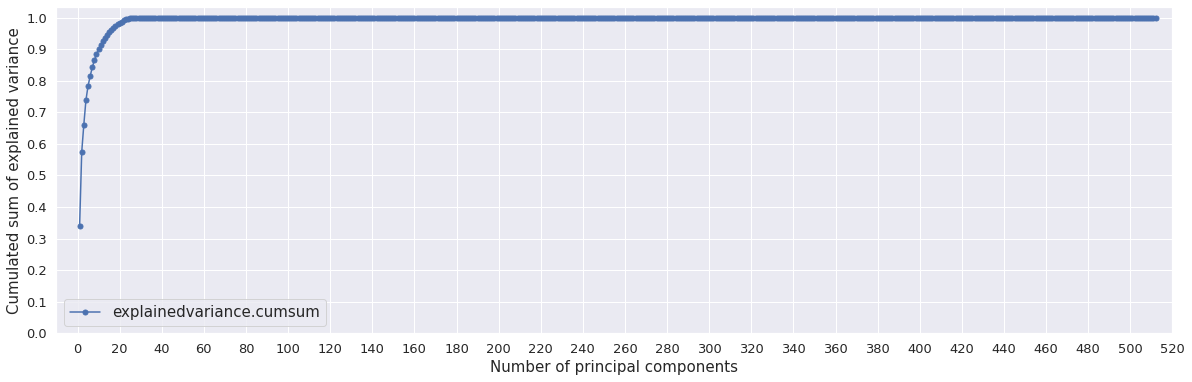

In [0]:
# Plot explainedvariance.cumsum
sns.set_theme()

plt.figure(figsize=(20,6))
g = plt.plot(np.arange(len(explainedvariance)) + 1,
             explainedvariance.cumsum(),
             marker='o',
             markersize=5,
             label='explainedvariance.cumsum')

plt.xticks(np.arange(0, 521, step = 20), size = 13)
plt.yticks(np.arange(0, 1.01, step = 0.1), size = 13)
plt.xlim(-10,520)
plt.xlabel('Number of principal components', fontsize=15)
plt.ylabel('Cumulated sum of explained variance', fontsize=15)
plt.legend(fontsize=15)

plt.show()

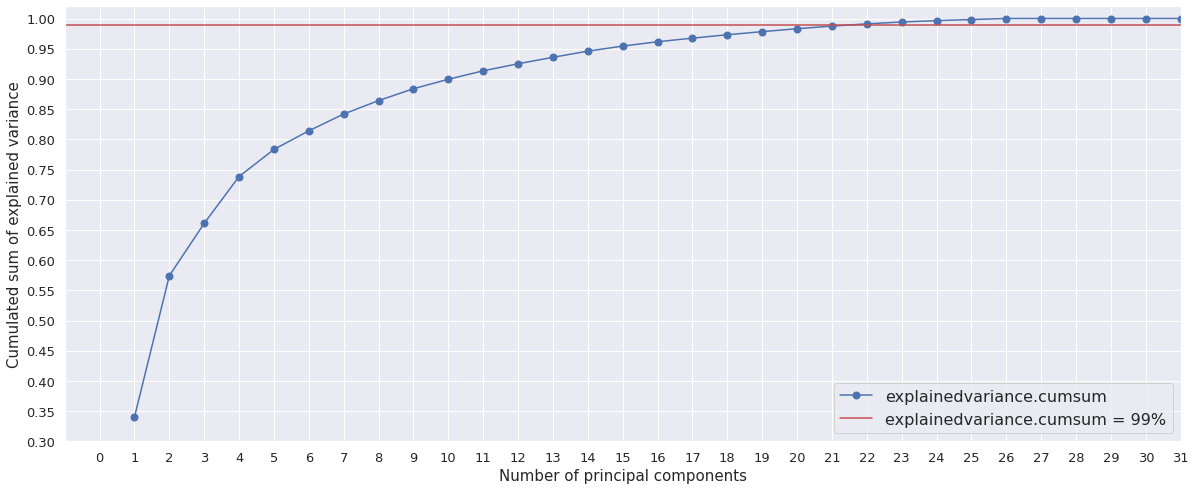

In [0]:
# Plot explainedvariance.cumsum #2
sns.set_theme()

plt.figure(figsize=(20,8))
g = plt.plot(np.arange(len(explainedvariance)) + 1,
             explainedvariance.cumsum(),
             marker='o',
             markersize=7,
             label='explainedvariance.cumsum')
h = plt.axhline(y=0.99, color='r', label='explainedvariance.cumsum = 99%')

plt.xticks(np.arange(0, 521, step=1), size=13)
plt.yticks(np.arange(0, 1.01, step=0.05), size=13)
plt.xlim(-1,31)
plt.ylim(0.3,1.02)
plt.xlabel('Number of principal components', fontsize=15)
plt.ylabel('Cumulated sum of explained variance', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [0]:
# Calculate the minimum number of components to reach 99% of variance
for component in range(512):
    var = explainedvariance.cumsum()[component]
    if var >= 0.99:
        n_components = component + 1
        print(f'{n_components} components explain 99% of variance')
        break

22 components explain 99% of variance


Applying PCA with n_components=22

In [0]:
# Define pca
pca = PCA(k=n_components, inputCol='vectors', outputCol='features_pca')

# Fit on features_max_dense
pca = pca.fit(features_max)

# Transform features
features_max = pca.transform(features_max)

In [0]:
features_max.show(truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                              path|                                          features|                                           vectors|                                      features_pca|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|dbfs:/FileStore/tables/resources/light_training...|[37.92189, 0.0, 10.638727, 0.0, 4.245837, 0.0, ...|[37.92189025878906,0.0,10.638727188110352,0.0,4...|[-187.04573857592777,181.8611154036777,-22.8985...|
|dbfs:/FileStore/tables/resources/light_training...|[62.419548, 0.0, 39.070755, 0.0, 7.708231, 0.0,...|[62.41954803466797,0.0,39.07075500488281,0.0,7....|[-173.22574374293865,1

2  with standardization of features

In [0]:
# Standardize features with StandardScaler
scaler = StandardScaler(inputCol="vectors", outputCol="vectors_std")
scaler = scaler.fit(features_max)
features_max_std = scaler.transform(features_max)

In [0]:
# Display the new dataframe features_max_dense_std
features_max_std.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                path|            features|             vectors|        features_pca|         vectors_std|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|dbfs:/FileStore/t...|[37.92189, 0.0, 1...|[37.9218902587890...|[-187.04573857592...|[1.81507539390962...|
|dbfs:/FileStore/t...|[62.419548, 0.0, ...|[62.4195480346679...|[-173.22574374293...|[2.98761968255070...|
|dbfs:/FileStore/t...|[0.04200101, 0.0,...|[0.04200100898742...|[-186.55046744580...|[0.00201031640069...|
|dbfs:/FileStore/t...|[55.715385, 7.614...|[55.7153854370117...|[-359.71725011142...|[2.66673481935602...|
|dbfs:/FileStore/t...|[17.053846, 18.42...|[17.0538463592529...|[-389.41403900858...|[0.81625722470469...|
|dbfs:/FileStore/t...|[1.2895622, 0.0, ...|[1.28956222534179...|[-397.36865833821...|[0.06172299556166...|
|dbfs:/FileStore/t...|[31.274214, 0.0

Searching the number of principal components that can explain 99% of the total of explained variance

In [0]:
# Define pca
pca = PCA(k=512, inputCol='vectors_std', outputCol='features_std_pca')

# Fit on features_max_dense
pca = pca.fit(features_max_std)

# Calculate explained variance for each feature
explainedvariance_std = pca.explainedVariance
explainedvariance_std

Out[72]: DenseVector([0.1893, 0.1018, 0.0971, 0.077, 0.0639, 0.0595, 0.0461, 0.0436, 0.0394, 0.0344, 0.031, 0.0279, 0.0251, 0.0233, 0.0222, 0.0196, 0.0183, 0.017, 0.0128, 0.0107, 0.01, 0.0084, 0.0073, 0.0061, 0.0045, 0.0039, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

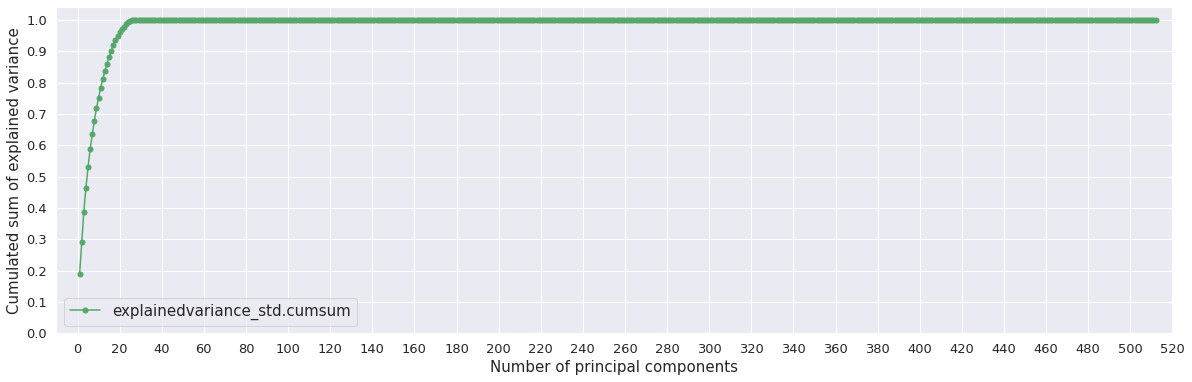

In [0]:
# Plot explainedvariance_std.cumsum
sns.set_theme()

plt.figure(figsize=(20,6))
g = plt.plot(np.arange(len(explainedvariance_std)) + 1,
             explainedvariance_std.cumsum(),
             color='g',
             marker='o',
             markersize=5,
             label='explainedvariance_std.cumsum')

plt.xticks(np.arange(0, 521, step = 20), size = 13)
plt.yticks(np.arange(0, 1.01, step = 0.1), size = 13)
plt.xlim(-10,520)
plt.xlabel('Number of principal components', fontsize=15)
plt.ylabel('Cumulated sum of explained variance', fontsize=15)
plt.legend(fontsize=15)

plt.show()

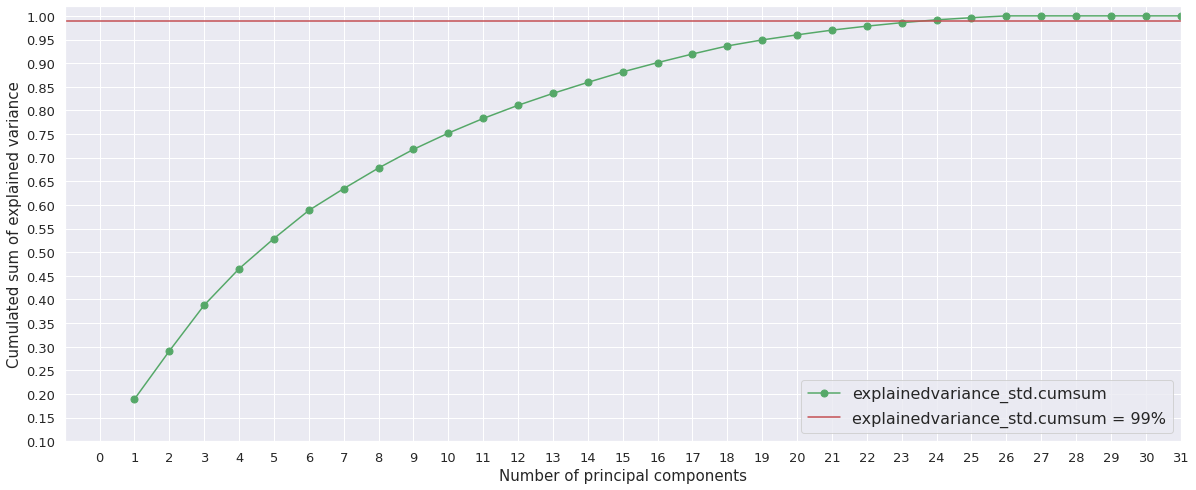

In [0]:
# Plot explainedvariance_std.cumsum #2
sns.set_theme()

plt.figure(figsize=(20,8))
g = plt.plot(np.arange(len(explainedvariance_std)) + 1,
             explainedvariance_std.cumsum(),
             color='g',
             marker='o',
             markersize=7,
             label='explainedvariance_std.cumsum')
h = plt.axhline(y=0.99, color='r', label='explainedvariance_std.cumsum = 99%')

plt.xticks(np.arange(0, 521, step=1), size=13)
plt.yticks(np.arange(0, 1.01, step=0.05), size=13)
plt.xlim(-1,31)
plt.ylim(0.1,1.02)
plt.xlabel('Number of principal components', fontsize=15)
plt.ylabel('Cumulated sum of explained variance', fontsize=15)
plt.legend(fontsize=16)

plt.show()

In [0]:
# Calculate the minimum number of components to reach 99.9% of variance
for component in range(512):
    var = explainedvariance_std.cumsum()[component]
    if var >= 0.99:
        n_components = component + 1
        print(f'{n_components} components explain 99% of variance')
        break

24 components explain 99% of variance


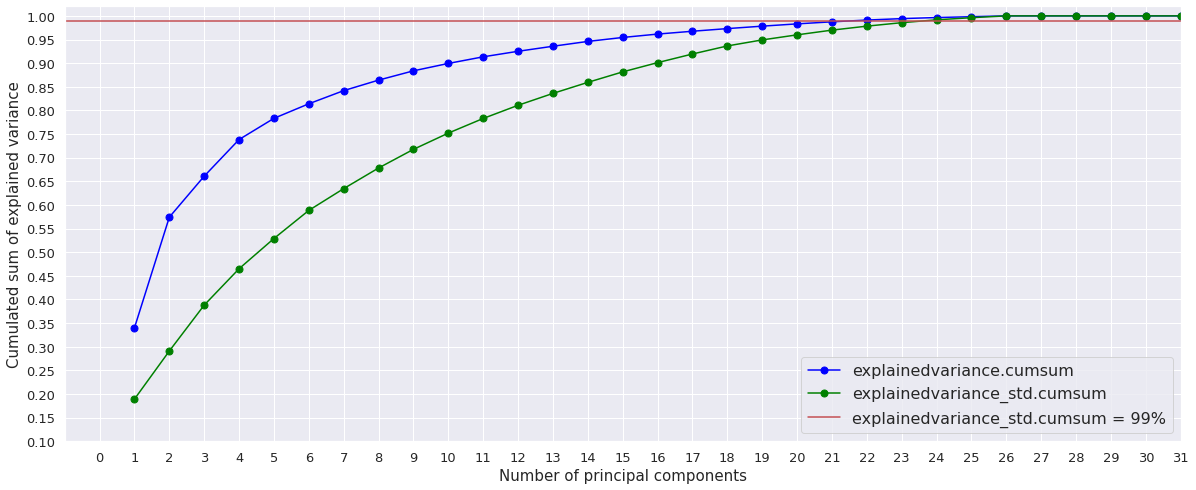

In [0]:
# Compare explainedvariance and explainedvariance_std
sns.set_theme()

plt.figure(figsize=(20,8))
g = plt.plot(np.arange(len(explainedvariance)) + 1,
             explainedvariance.cumsum(),
             color='blue',
             marker='o',
             markersize=7,
             label='explainedvariance.cumsum')
g_std = plt.plot(np.arange(len(explainedvariance_std)) + 1,
                 explainedvariance_std.cumsum(),
                 color='green',
                 marker='o',
                 markersize=7,
                 label='explainedvariance_std.cumsum')
h = plt.axhline(y=0.99, color='r', label='explainedvariance_std.cumsum = 99%')

plt.xticks(np.arange(0, 521, step=1), size=13)
plt.yticks(np.arange(0, 1.01, step=0.05), size=13)
plt.xlim(-1,31)
plt.ylim(0.1,1.02)
plt.xlabel('Number of principal components', fontsize=15)
plt.ylabel('Cumulated sum of explained variance', fontsize=15)
plt.legend(fontsize=16)

plt.show()

Applying PCA with n_components=24

In [0]:
# Define pca
pca = PCA(k=n_components, inputCol='vectors_std', outputCol='features_std_pca')

# Fit on features_max_std
pca = pca.fit(features_max_std)

# Transform features
features_max_std = pca.transform(features_max_std)

In [0]:
features_max_std.show(truncate=30)

+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                          path|                      features|                       vectors|                  features_pca|                   vectors_std|              features_std_pca|
+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|dbfs:/FileStore/tables/reso...|[37.92189, 0.0, 10.638727, ...|[37.92189025878906,0.0,10.6...|[-187.04573857592777,181.86...|[1.815075393909629,0.0,1.31...|[-6.057330233087139,-3.1998...|
|dbfs:/FileStore/tables/reso...|[62.419548, 0.0, 39.070755,...|[62.41954803466797,0.0,39.0...|[-173.22574374293865,154.65...|[2.987619682550703,0.0,4.84...|[-6.0897772346644805,-3.391...|
|dbfs:/FileStore/tables/reso...|[0.04200101, 0.0, 5.6153793.

In [0]:
# Select useful columns before the save
features_max_std_pca = features_max_std.select('path', 'features_std_pca')

In [0]:
# Create the column "class" containing the fruit class of each image
# by extracting the fruit class from the image path
features_max_std_pca = features_max_std_pca.withColumn(
    colName="class", 
    col=element_at(
        col=split(
            features_max_std_pca["path"], 
            "/"),  # split the path with the "/" character
        extraction=-2))  # extract the penultimate string in the binary_train["path"]

In [0]:
features_max_std_pca.show(truncate=80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+------------------+
|                                                                            path|                                                                features_std_pca|             class|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+------------------+
|              dbfs:/FileStore/tables/resources/light_training_4/Kiwi/134_100.jpg|[-6.057330233087139,-3.1998405604559226,-5.345224357761596,-2.060857096718972...|              Kiwi|
|                dbfs:/FileStore/tables/resources/light_training_4/Kiwi/0_100.jpg|[-6.0897772346644805,-3.3917218569685077,-4.357278537691967,-1.58814973334719...|              Kiwi|
|            dbfs:/FileStore/tables/resources/light_training_4/Kiwi/r_307_100.jpg|[-4

In [0]:
# Save the last dataframe features_max_std_pca
features_max_std_pca.write.mode("overwrite").parquet("dbfs:/FileStore/tables/features_max_std_pca")